In [51]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 20
})

In [52]:
df = None

alias = {
    "energy_based_run": "EnergyBasedController",
    "pure_ppo_eval_200000": "VanillaPPO_undertrained",
    "pure_ppo_eval_500000": "VanillaPPO_welltrained",
    "pure_ppo_with_calfw_eval_200000": "VanillaPPO_undertrained+CALFWrapper",
    "pure_ppo_with_calfw_eval_500000": "VanillaPPO_welltrained+CALFWrapper",
}

for root, dirs, files in os.walk("../logs"):
    for fn in files:
        
        if not fn.endswith(".csv") or "seed" not in fn:
            continue
        file_path = os.path.join(root, fn)

        tmp_df = pd.read_csv(file_path, sep=',')
        
        # Convert string to array
        for k in tmp_df:            
            tmp_df[k] = tmp_df[k].apply(lambda x: x if not isinstance(x, str) else np.fromstring(
                                        x.replace('\n','')
                                        .replace('[','')
                                        .replace(']','')
                                        .replace('  ',' '), sep=' '))
            
        tmp_df["action"] = tmp_df["action"].apply(lambda x: x[0])
        tmp_df["reward"] = tmp_df["reward"].apply(lambda x: x[0])
        tmp_df["accumulated_reward"] = tmp_df["accumulated_reward"].apply(lambda x: x[0])
        # if "relax_probability" in tmp_df.columns:
        #     tmp_df["relax_probability"] = tmp_df["relax_probability"].apply(lambda x: x[0] if x else x)

        tmp_df["x"] = tmp_df["state"].apply(lambda x: x[0])
        tmp_df["y"] = tmp_df["state"].apply(lambda x: x[1])
        tmp_df["angular_vel"] = tmp_df["state"].apply(lambda x: x[2])

        tmp_df["file_name"] = fn
        for k in alias:
            if k in fn:
                tmp_df["Case"] = alias[k]
                break
        
        if df is None:
            df = tmp_df
        else:
            df = pd.concat([df, tmp_df])

In [53]:
df.columns = ["step"] + df.columns[1:].tolist()
df.head()

,step,state,action,reward,accumulated_reward,x,y,angular_vel,file_name,Case,relax_probability,calf_activated_count
0,0,"[-0.08676992, -0.9962284, -1.5503604]",0.0,-2.560961,-2.560961,-0.086770,-0.996228,-1.550360,energy_based_run_seed_33.csv,EnergyBasedController,NaN,NaN
1,1,"[-0.20038977, -0.97971624, -2.2975316]",0.0,-2.988250,-5.549210,-0.200390,-0.979716,-2.297532,energy_based_run_seed_33.csv,EnergyBasedController,NaN,NaN
2,2,"[-0.34606314, -0.9382112, -3.0323188]",0.0,-3.669806,-9.219016,-0.346063,-0.938211,-3.032319,energy_based_run_seed_33.csv,EnergyBasedController,NaN,NaN
3,3,"[-0.5142823, -0.85762095, -3.7359774]",0.0,-4.621918,-13.840935,-0.514282,-0.857621,-3.735977,energy_based_run_seed_33.csv,EnergyBasedController,NaN,NaN
4,4,"[-0.6882907, -0.72543496, -4.379193]",0.0,-5.851934,-19.692869,-0.688291,-0.725435,-4.379193,energy_based_run_seed_33.csv,EnergyBasedController,NaN,NaN


In [54]:
import matplotlib.colors as mcolors

color_list = list(mcolors.TABLEAU_COLORS.keys())
case_colors = {c:color_list[i] for i, c in enumerate(df.Case.unique())}
case_colors

{'EnergyBasedController': 'tab:blue',
 'VanillaPPO_welltrained': 'tab:orange',
 'VanillaPPO_undertrained': 'tab:green',
 'VanillaPPO_undertrained+CALFWrapper': 'tab:red',
 'VanillaPPO_welltrained+CALFWrapper': 'tab:purple'}

In [56]:
df.loc[:, ["Case", "file_name"]].groupby(["Case"]).nunique()

,file_name
Case,
EnergyBasedController,31
VanillaPPO_undertrained,31
VanillaPPO_undertrained+CALFWrapper,31
VanillaPPO_welltrained,31
VanillaPPO_welltrained+CALFWrapper,31


In [88]:
# df.loc[:, ["Case", "file_name"]].groupby(["Case"]).nunique()
group_df = df.loc[:, ["Case", "file_name", "accumulated_reward"]].groupby(["Case", "file_name"]).last()
group_df = group_df.reset_index().drop(columns=["file_name"])
group_df.columns = ["last_accumulated_reward" if column == "accumulated_reward" else column for column in group_df.columns]
group_df.groupby("Case").agg({
    "last_accumulated_reward": ["std", "min", "mean", "max"]
})

last_accumulated_reward               \
                                                        std          min   
Case                                                                       
EnergyBasedController                            148.013861  -713.695631   
VanillaPPO_undertrained                          212.503581 -4195.037028   
VanillaPPO_undertrained+CALFWrapper              190.502810  -782.026700   
VanillaPPO_welltrained                          1939.894744 -5208.666783   
VanillaPPO_welltrained+CALFWrapper               163.315423  -672.130250   

                                                               
                                            mean          max  
Case                                                           
EnergyBasedController                -295.801917  -118.215553  
VanillaPPO_undertrained             -3676.937534 -3139.480793  
VanillaPPO_undertrained+CALFWrapper  -352.379878  -115.577590  
VanillaPPO_welltrained              -1493.766895   -10.150083  
VanillaPPO_welltrained+CALFWrapper   -342.608928  -115.761260

Text(0.5, 1.0, 'Acumulated Reward Comparison')

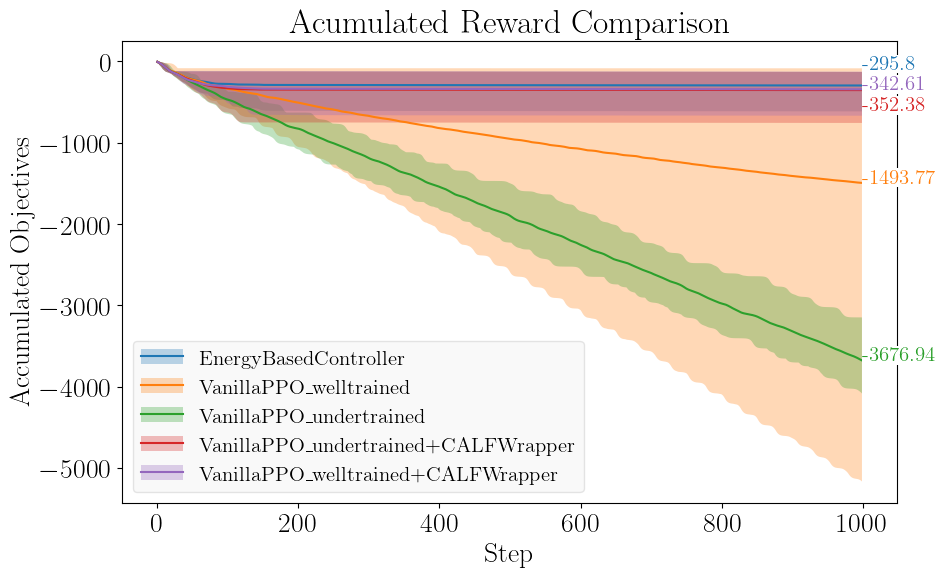

In [72]:
from scipy.interpolate import interp1d

def plot_ic(df, ax, 
            y_label="accumulated_reward",
            low_quantile=0.025, 
            high_quantile=0.975, 
            color=None, 
            use_interpolate=False,
            is_truncate=True):
    def quantile_low(series):
        return series.quantile(low_quantile)

    def quantile_high(series):
        return series.quantile(high_quantile)

    tmp_df = df.copy()
    ic_95_df = tmp_df.groupby("step").agg({y_label: [quantile_low, quantile_high]})

    # Plot
    if not use_interpolate:
        X_ = ic_95_df.index
        Y_hi = ic_95_df[y_label].quantile_high
        Y_lo = ic_95_df[y_label].quantile_low
    else:
        cubic_interpolation_model_hi = interp1d(ic_95_df.index, 
                                                ic_95_df[y_label].quantile_high, kind = "cubic")
        
        cubic_interpolation_model_lo = interp1d(ic_95_df.index, 
                                                ic_95_df[y_label].quantile_low, kind = "cubic")
    
        # Plotting the Graph
        X_=np.linspace(ic_95_df.index.min(), ic_95_df.index.max(), 40)
        Y_hi=cubic_interpolation_model_hi(X_)
        Y_lo=cubic_interpolation_model_lo(X_)
    
    p = ax.fill_between(X_, 
                        Y_hi, Y_lo, 
                        facecolor=color,
                        alpha=0.3)
    
    ax.set_xlabel("Step")
    ax.set_ylabel("Accumulated Objectives")

    return p

def plot_mean(df, ax, 
            y_label="accumulated_reward",
            low_quantile=0.025, 
            high_quantile=0.975, 
            color=None, 
            use_interpolate=False,
            is_truncate=True,
            bias=[0,0]):
    tmp_df = df.copy()
    mean_df = tmp_df.loc[:, ["step", y_label]].groupby("step").mean()

    # Plot
    if not use_interpolate:
        X_ = mean_df.index
        Y_ = mean_df[y_label]
    else:        
        cubic_interpolation_model_mean = interp1d(mean_df.index, 
                                                  mean_df[y_label], kind = "cubic")
    
        # Plotting the Graph
        X_=np.linspace(mean_df.index.min(), mean_df.index.max(), 40)
        Y_=cubic_interpolation_model_mean(X_)
    
    p = ax.plot(X_, 
                Y_,
                color=color,
                alpha=1)

    ax.annotate(str(Y_.values[-1].round(2)), 
        (
            X_.values[-1] + bias[0], # X
            Y_.values[-1] + bias[1], # Y
            ),
            color=color,
            bbox=dict(facecolor='white', edgecolor="None", pad=0.2),
            fontsize=15)
    
    ax.set_xlabel("Step")
    ax.set_ylabel("Accumulated Objectives")
    
    return p[0]

tmp_df = df.set_index(["Case"])
y_label = "accumulated_reward"

fig, ax = plt.subplots(figsize=(10, 6))

legend_info = {}

anotation_bias = {
    "EnergyBasedController": [0, 200],
    "VanillaPPO_undertrained": [0, 0],
    "VanillaPPO_undertrained+CALFWrapper": [0, -250],
    "VanillaPPO_welltrained": [0, 0],
    "VanillaPPO_welltrained+CALFWrapper": [0, 0],
}

for c in tmp_df.index.unique():
    p_m = plot_mean(tmp_df.loc[c], y_label=y_label, ax=ax, color=case_colors[c], bias=anotation_bias[c])
    p_ic = plot_ic(tmp_df.loc[c], y_label=y_label, ax=ax, color=case_colors[c])

    legend_info[c] = (p_m, p_ic)

legend = ax.legend(legend_info.values(), 
                   legend_info.keys(),
                   facecolor='whitesmoke', 
                   framealpha=0.5,
                   prop={'size': 15})

ax.set_title("Acumulated Reward Comparison")


In [47]:
legend_info

{'EnergyBasedController': ([<matplotlib.lines.Line2D at 0x7490694b3f10>],
  <matplotlib.collections.PolyCollection at 0x749069395e90>),
 'VanillaPPO_welltrained': ([<matplotlib.lines.Line2D at 0x74906938a490>],
  <matplotlib.collections.PolyCollection at 0x7490693b51d0>),
 'VanillaPPO_undertrained': ([<matplotlib.lines.Line2D at 0x7490701efa90>],
  <matplotlib.collections.PolyCollection at 0x7490693b6810>),
 'VanillaPPO_undertrained+CALFWrapper': ([<matplotlib.lines.Line2D at 0x74906931c350>],
  <matplotlib.collections.PolyCollection at 0x7490693ad610>),
 'VanillaPPO_welltrained+CALFWrapper': ([<matplotlib.lines.Line2D at 0x7490693b7050>],
  <matplotlib.collections.PolyCollection at 0x7490693ae650>)}

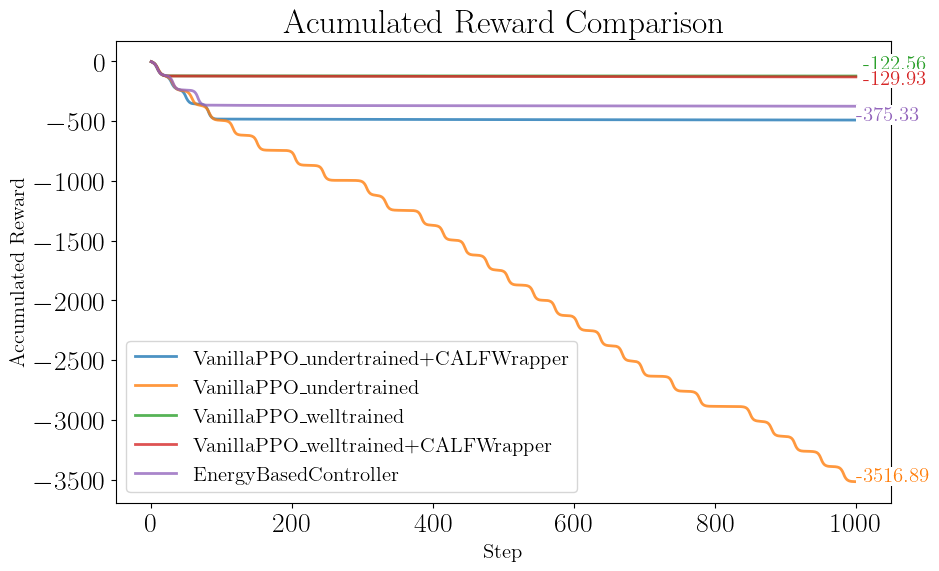

In [294]:
def plot_accum_reward(df, y_label="accumulated_reward"):
    tmp_df = df.set_index(["Case"])
    fig, ax = plt.subplots(figsize=(10, 6))
    for c in df.Case.unique():
        p = tmp_df.loc[c].plot(x="step", y=y_label, ax=ax, label=c, lw=2, alpha=0.8)

        bias = [0, 0]

        if c == "VanillaPPO_welltrained+CALFWrapper":
            bias = [10, -60]
        elif c == "VanillaPPO_welltrained":
            bias = [10, 60]
        elif c == "EnergyBasedController":
            bias = [0, -120]

        current_color = ax.get_lines()[-1].get_color()
        ax.annotate(str(tmp_df.loc[c][y_label].values[-1].round(2)), 
                    (
                        tmp_df.loc[c].step.values[-1] + bias[0], # X
                        tmp_df.loc[c][y_label].values[-1] + bias[1], # Y
                     ),
                     color=current_color,
                     bbox=dict(facecolor='white', edgecolor="None", pad=0.2),
                     fontsize=15)

    ax.set_xlabel("Step", fontsize=15)
    ax.set_ylabel("Accumulated Reward", fontsize=15)
    # ax.set_yscale("log")
    ax.legend(prop={'size': 15})
    ax.set_title("Acumulated Reward Comparison")

    fig.savefig("../media/" + "accumulated_reward.png")

plot_accum_reward(df, y_label="accumulated_reward")

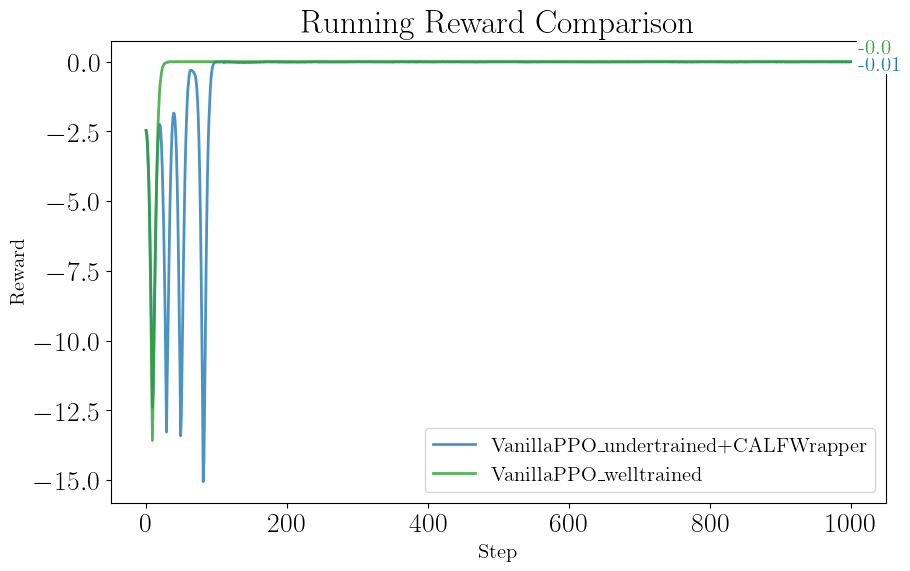

In [295]:
def plot_immediate_reward(df, y_label="accumulated_reward"):
    tmp_df = df.set_index(["Case"])
    fig, ax = plt.subplots(figsize=(10, 6))
    for c in df.Case.unique():
        if c not in [
            "VanillaPPO_undertrained+CALFWrapper",
            "VanillaPPO_welltrained",
        ]:
            continue

        color = {
            "VanillaPPO_undertrained+CALFWrapper": "tab:blue",
            "VanillaPPO_welltrained": "tab:green"
        }

        p = tmp_df.loc[c].plot(x="step", y=y_label, ax=ax, label=c, lw=2, alpha=0.8, color=color)

        bias = [0, 0]

        if c == "VanillaPPO_undertrained+CALFWrapper":
            bias = [10, -0.3]
        elif c == "VanillaPPO_welltrained":
            bias = [10, .3]

        current_color = ax.get_lines()[-1].get_color()
        ax.annotate(str(tmp_df.loc[c][y_label].values[-1].round(2)), 
                    (
                        tmp_df.loc[c].step.values[-1] + bias[0], # X
                        tmp_df.loc[c][y_label].values[-1] + bias[1], # Y
                     ),
                     color=current_color,
                     bbox=dict(facecolor='white', edgecolor="None", pad=0.2),
                     fontsize=15)

    ax.set_xlabel("Step", fontsize=15)
    ax.set_ylabel("Reward", fontsize=15)
    # ax.set_yscale("log")
    ax.legend(prop={'size': 15})
    ax.set_title("Running Reward Comparison")
    fig.savefig("../media/" + "running_reward.png")

plot_immediate_reward(df, y_label="reward")

VanillaPPO_undertrained+CALFWrapper
VanillaPPO_undertrained
VanillaPPO_welltrained
VanillaPPO_welltrained+CALFWrapper
EnergyBasedController


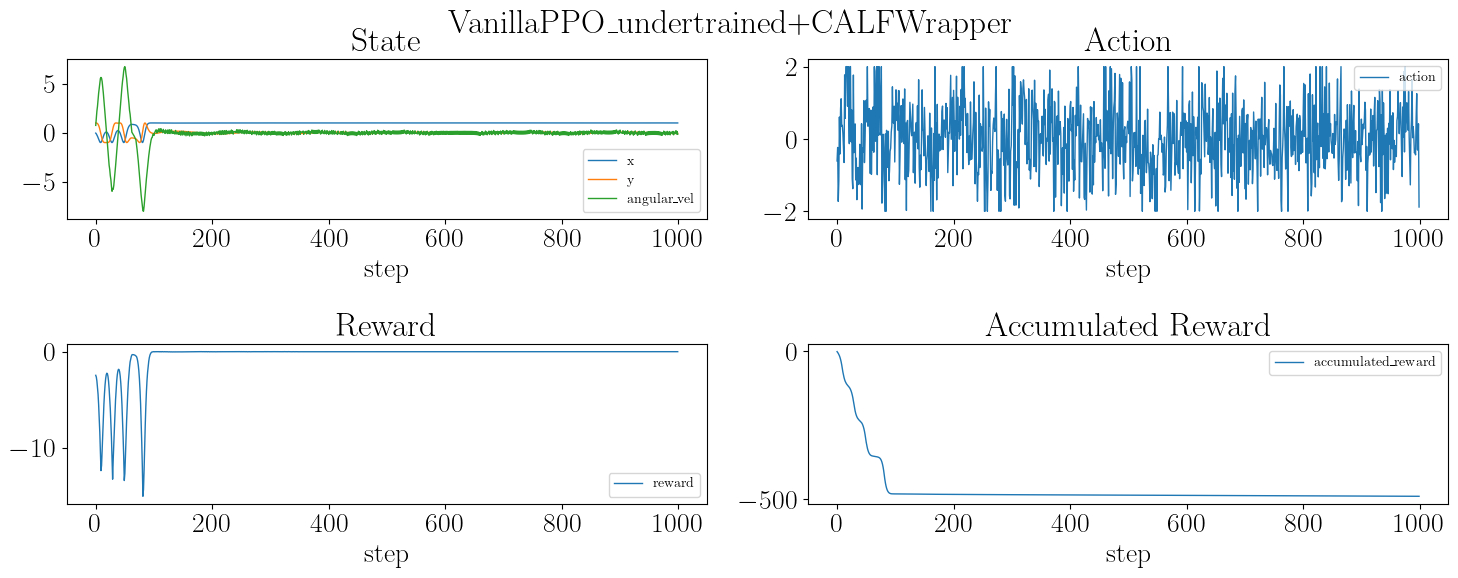

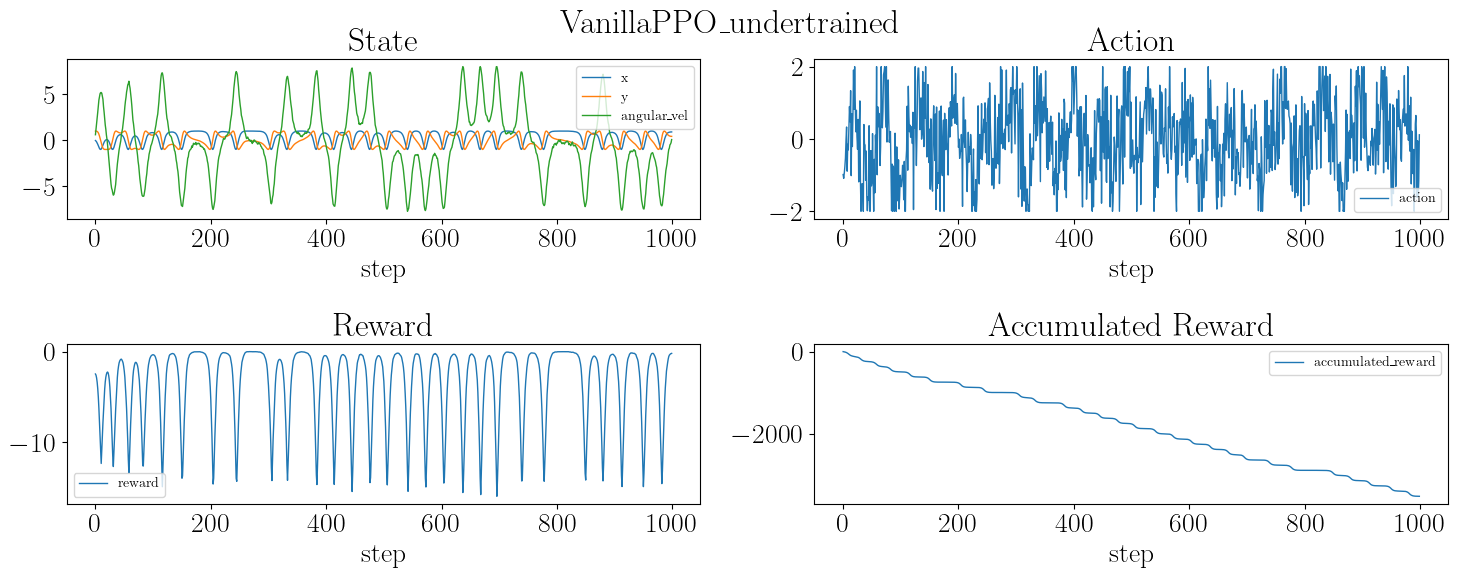

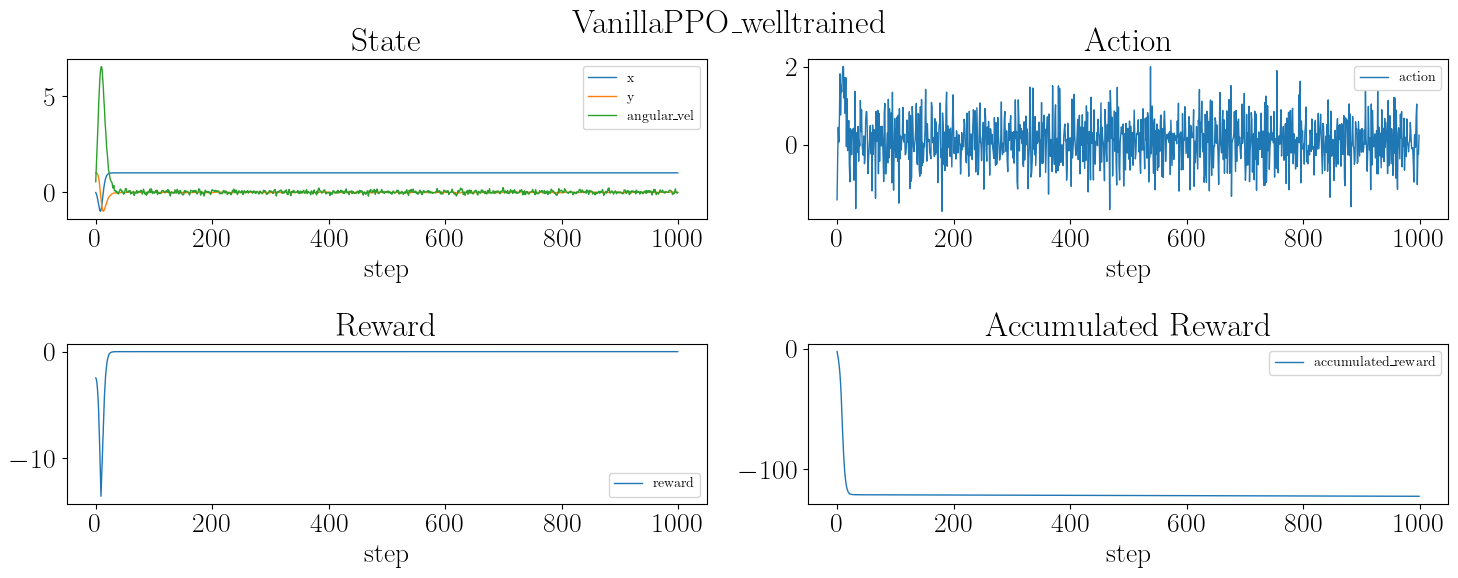

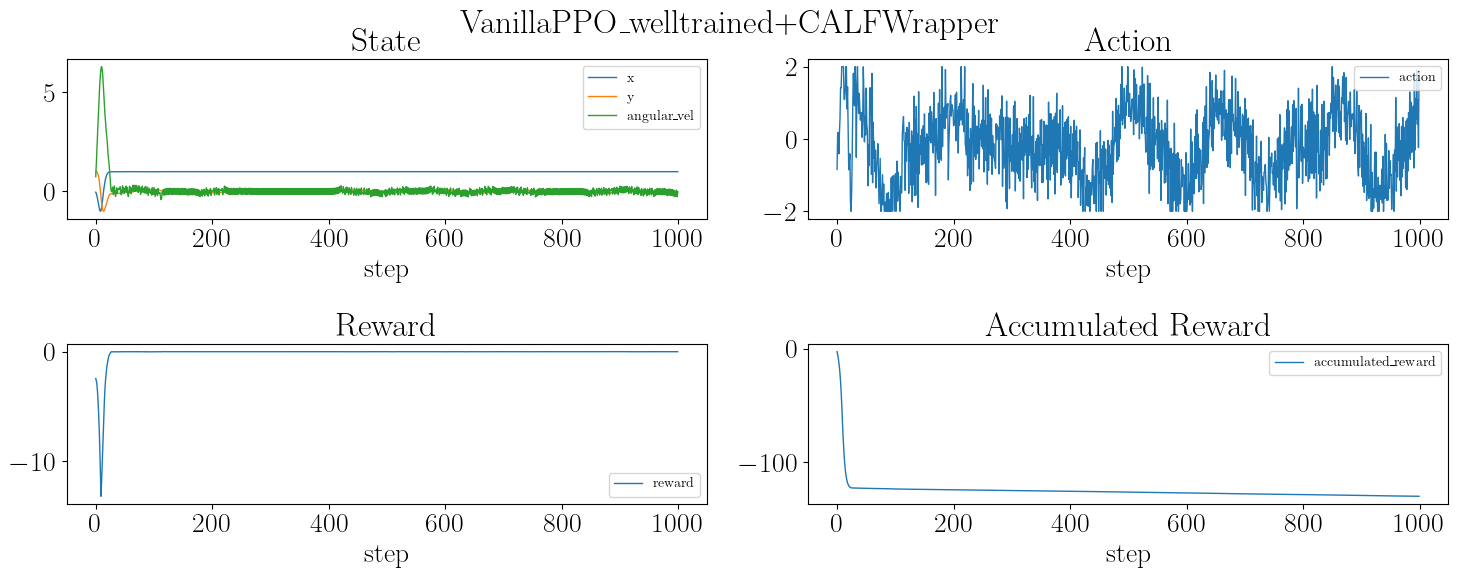

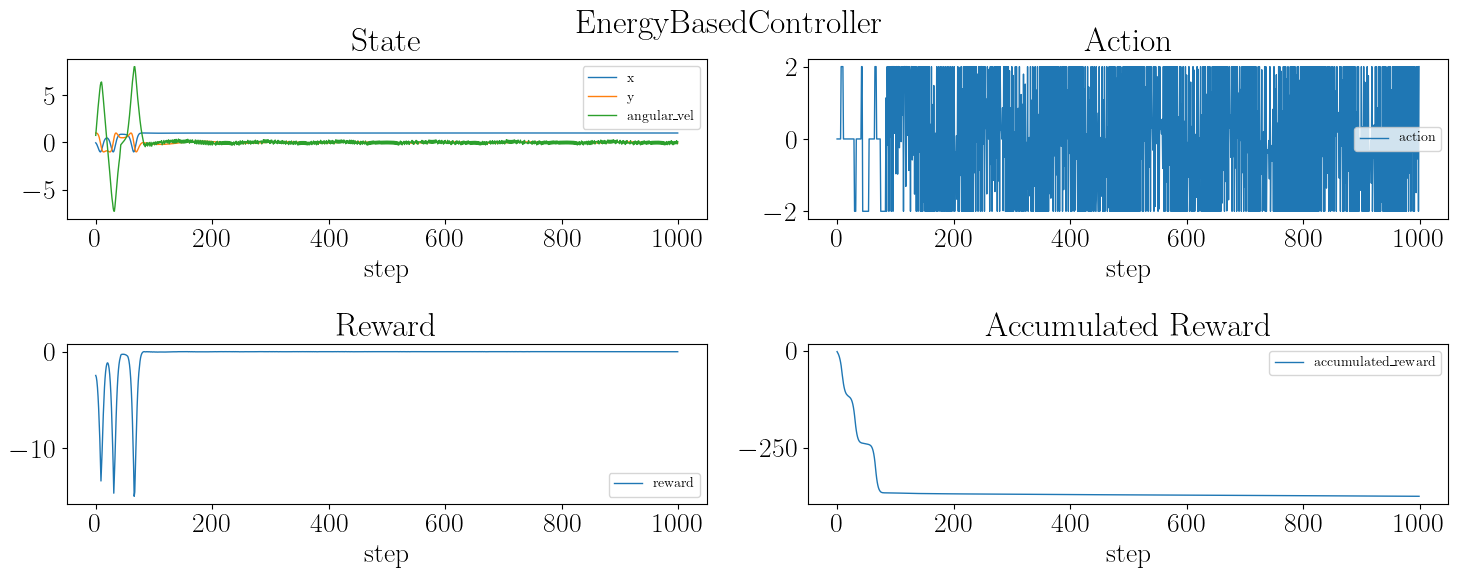

In [296]:
for c in df.Case.unique():
    print(c)

    tmp_df = df.set_index(["Case"])
    fig, ax = plt.subplots(2, 2, figsize=(15, 6))

    tmp_df.loc[c].plot(x="step", y="x", ax=ax[0][0], lw=1)
    tmp_df.loc[c].plot(x="step", y="y", ax=ax[0][0], lw=1)
    tmp_df.loc[c].plot(x="step", y="angular_vel", ax=ax[0][0], lw=1)
    ax[0][0].set_title("State")

    tmp_df.loc[c].plot(x="step", y="action", ax=ax[0][1], lw=1)
    ax[0][1].set_title("Action")

    tmp_df.loc[c].plot(x="step", y="reward", ax=ax[1][0], lw=1)
    ax[1][0].set_title("Reward")

    tmp_df.loc[c].plot(x="step", y="accumulated_reward", ax=ax[1][1], lw=1)
    ax[1][1].set_title("Accumulated Reward")

    # plt.title("VanillaPPO_undertrained+CALFWrapper")
    ax[0][0].legend(prop={'size': 10})
    ax[0][1].legend(prop={'size': 10})
    ax[1][1].legend(prop={'size': 10})
    ax[1][0].legend(prop={'size': 10})
    plt.tight_layout()
    fig.suptitle(c) # or plt.suptitle('Main title')
    fig.savefig("../media/" + c + ".png")

    

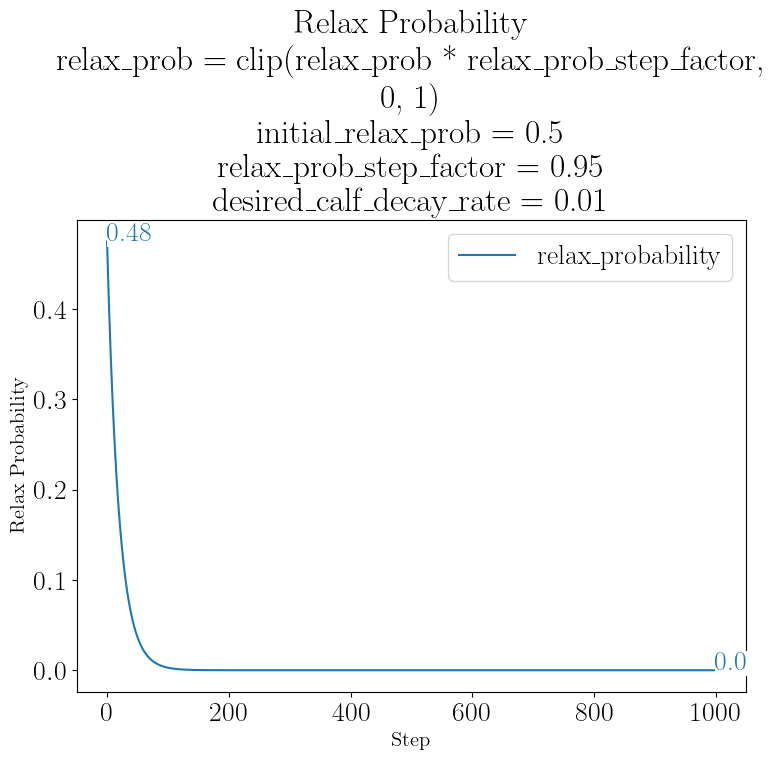

In [297]:
def plot_relax_prob(df, ax=None, c = "VanillaPPO_undertrained+CALFWrapper"):
    y_label = "relax_probability"

    if ax is None:
        fig, _ax = plt.subplots(figsize=(8, 8))
    else:
        _ax = ax
    tmp_df = df.set_index(["Case"])
    tmp_df.loc[c].plot(x="step", y=y_label, ax=_ax)

    current_color = _ax.get_lines()[-1].get_color() 
    _ax.annotate(str(tmp_df.loc[c][y_label].values[0].round(2)), 
                        (
                            tmp_df.loc[c].step.values[0], # X
                            tmp_df.loc[c][y_label].values[0], # Y
                        ),
                        color=current_color,
                        bbox=dict(facecolor='white', edgecolor="None", pad=0.2))
    
    _ax.annotate(str(tmp_df.loc[c][y_label].values[-1].round(2)), 
                    (
                        tmp_df.loc[c].step.values[-1], # X
                        tmp_df.loc[c][y_label].values[-1], # Y
                    ),
                    color=current_color,
                    bbox=dict(facecolor='white', edgecolor="None", pad=0.2))

    _ax.set_xlabel("Step", fontsize=15)
    _ax.set_ylabel("Relax Probability", fontsize=15)
    _ax.legend()
    _ax.set_title("Relax Probability\n" + 
                 "relax_prob = clip(relax_prob * relax_prob_step_factor,\n 0, 1)\n" + 
                 "initial_relax_prob = 0.5\nrelax_prob_step_factor = 0.95\n" +
                 "desired_calf_decay_rate = 0.01")
    plt.tight_layout()

    if ax is None:
        fig.savefig("../media/" + "relax_probability.png")
# relax_prob = np.clip(relax_prob * relax_prob_step_factor, 0, 1)
plot_relax_prob(df)

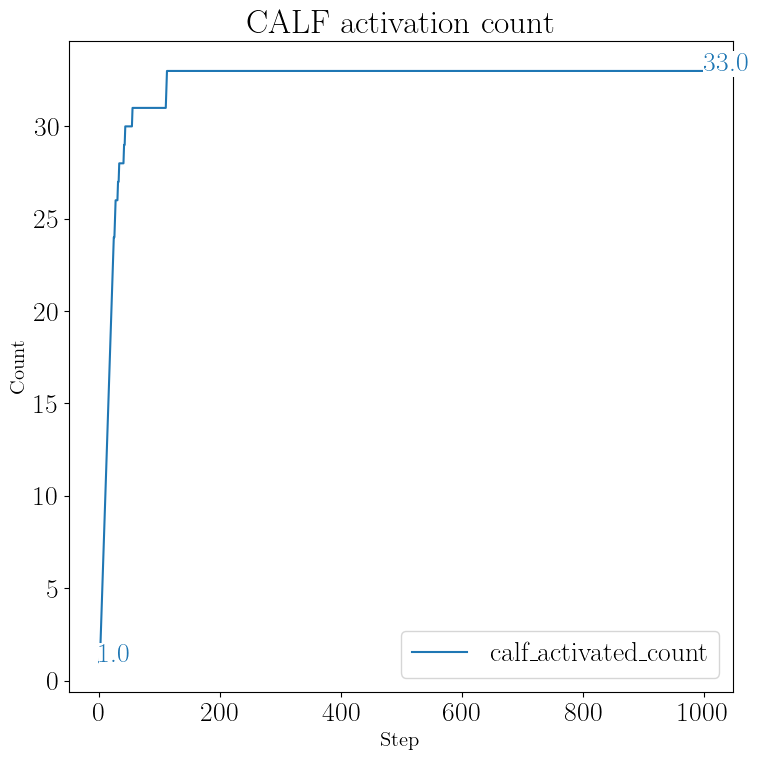

In [298]:
def plot_activated_count(df, ax=None, c="VanillaPPO_welltrained+CALFWrapper"):
    
    y_label = "calf_activated_count"

    if ax is None:
        fig, _ax = plt.subplots(figsize=(8, 8))
    else:
        _ax = ax
    tmp_df = df.set_index(["Case"])
    tmp_df.loc[c].plot(x="step", y=y_label, ax=_ax)

    current_color = _ax.get_lines()[-1].get_color() 
    _ax.annotate(str(tmp_df.loc[c][y_label].values[0].round(2)), 
                        (
                            tmp_df.loc[c].step.values[0], # X
                            tmp_df.loc[c][y_label].values[0], # Y
                        ),
                        color=current_color,
                        bbox=dict(facecolor='white', edgecolor="None", pad=0.2))
    
    _ax.annotate(str(tmp_df.loc[c][y_label].values[-1].round(2)), 
                    (
                        tmp_df.loc[c].step.values[-1], # X
                        tmp_df.loc[c][y_label].values[-1], # Y
                    ),
                    color=current_color,
                    bbox=dict(facecolor='white', edgecolor="None", pad=0.2))

    _ax.set_xlabel("Step", fontsize=15)
    _ax.set_ylabel("Count", fontsize=15)
    _ax.legend()
    _ax.set_title("CALF activation count")

    plt.tight_layout()
    
    if ax is None:
        fig.savefig("../media/" + "relax_probability.png")
# relax_prob = np.clip(relax_prob * relax_prob_step_factor, 0, 1)
plot_activated_count(df)

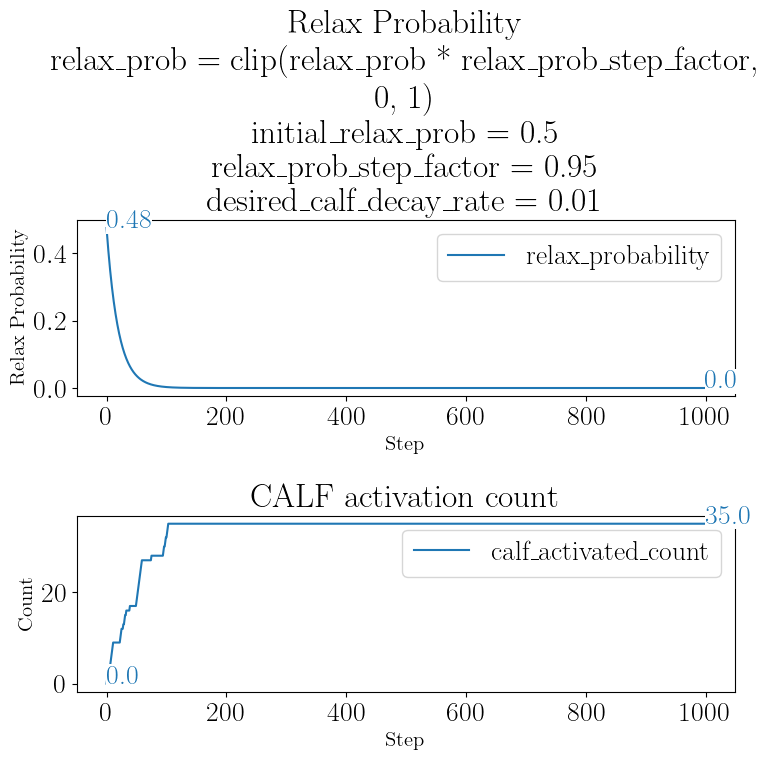

In [299]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
c = "VanillaPPO_welltrained+CALFWrapper"
c = "VanillaPPO_undertrained+CALFWrapper"
plot_relax_prob(df, ax[0], c=c)
plot_activated_count(df, ax[1], c=c)

In [300]:
df.x.describe()

count    5000.000000
mean        0.824325
std         0.452546
min        -0.999988
25%         0.993748
50%         0.998929
75%         0.999866
max         1.000000
Name: x, dtype: float64